# Ottimizzazione con Optuna

In [ ]:
!pip install optuna
import optuna
import joblib #per salvare lo studio in caso colab mi scollegasse

In [ ]:
def objective(trial,train_ldr,val_ldr):
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2,log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-9, 1e-4,log=True)
    channels = trial.suggest_int('channels',2,24)

    scaler = torch.amp.GradScaler() #uso di float16 invece che float32 per velocizzare il training. Nonostante sia molto semplice come modello (ed essendo i risparmi quasi nulli), dovendo runnare 200 volte il training, ogni ottimizzazione aiuta
    model = CAE(channels).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, threshold=0.0001)

    patience=30
    val_loss = []
    train_loss = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs=300

    for epoch in range(epochs):
        #train
        model.train()
        running_loss = 0.0
        for data in train_ldr:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'): #f16
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_ldr.dataset)
        train_loss.append(epoch_loss)

        #validation
        model.eval()
        val_loss_running = 0.0
        with torch.no_grad():
            for data in val_ldr:
                inputs = data[0].to(device)
                outputs = model(inputs)

                loss = criterion(outputs, inputs)
                val_loss_running += loss.item() * inputs.size(0)

        val_epoch_loss = val_loss_running / len(val_ldr.dataset)
        val_loss.append(val_epoch_loss)
        current_lr = optimizer.param_groups[0]['lr']

        #early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping after {patience} epochs without improvement.')
                break

        scheduler.step(val_epoch_loss)

        #pruning del trial
        trial.report(val_epoch_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return val_epoch_loss
study = optuna.create_study(directions=['minimize']) #minimizzo loss di validazione

In [ ]:
for i in range(100):
  study.optimize(lambda trial: objective(trial, train_ldr,val_ldr,pos_weight),n_trials=1)
  joblib.dump(study, f"MSE_1conv_{i}.pkl")

# Calcolo media e std delle frazioni di eventi anomali

In [ ]:
def trainEvaluate(train_data, validation_data, test_l_data, test_h_data, batch_size, epochs, learning_rate, weight_decay, seed):

    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    train_ldr, val_ldr, val_ldr_1b, test_h_ldr, test_l_ldr = createDataloaders(train_data, validation_data, test_h_data, test_l_data, batch_size)

    model = CAE(4).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 30

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data in train_ldr:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_ldr:
                inputs = data[0].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)

        val_epoch_loss = val_loss / len(val_ldr.dataset)

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                break
        scheduler.step(val_epoch_loss)

    reconstruction_criterion = nn.MSELoss()
    recon_err_val = calculateReconstructionErrors(val_ldr_1b, model, reconstruction_criterion, device)
    recon_err_l = calculateReconstructionErrors(test_l_ldr, model, reconstruction_criterion, device)
    recon_err_h = calculateReconstructionErrors(test_h_ldr, model, reconstruction_criterion, device)

    scaler = MaxAbsScaler()
    scaler.fit(recon_err_val.reshape(-1, 1))
    norm_err_val = scaler.transform(recon_err_val.reshape(-1, 1))
    norm_err_l = scaler.transform(recon_err_l.reshape(-1, 1))
    norm_err_h = scaler.transform(recon_err_h.reshape(-1, 1))

    anomaly_threshold = np.percentile(norm_err_val, 90)

    labels_l = (norm_err_l > anomaly_threshold).astype(int)
    labels_h = (norm_err_h > anomaly_threshold).astype(int)

    f_anomal_l = np.sum(labels_l) / len(labels_l)
    f_anomal_h = np.sum(labels_h) / len(labels_h)

    return f_anomal_l, f_anomal_h


Run 1/10

Run 2/10

Run 3/10

Run 4/10

Run 5/10

Run 6/10

Run 7/10

Run 8/10

Run 9/10

Run 10/10

Finito.

Frazione anomalie Low): 0.4373 ± 0.0059
Frazione anomalie High: 0.9183 ± 0.0033


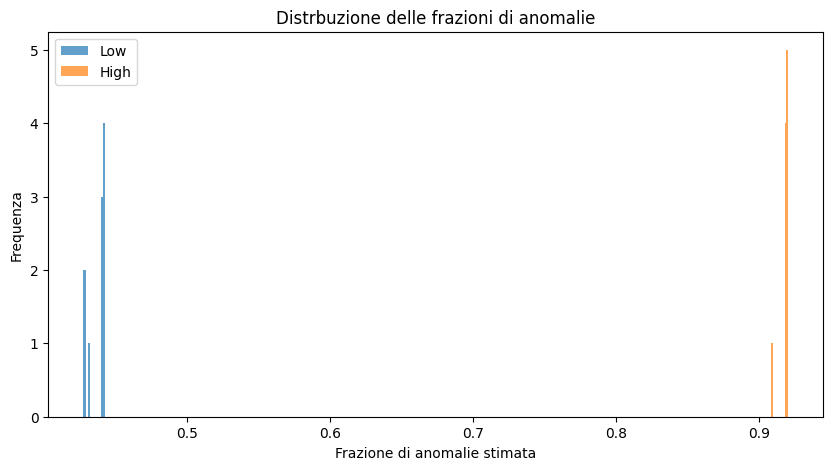

In [ ]:
num_runs = 10
estimated_fractions_l = []
estimated_fractions_h = []

train_data_orig = np.copy(train)
validation_data_orig = np.copy(validation)
test_l_data_orig = np.copy(test_l)
test_h_data_orig = np.copy(test_h)

for i in range(num_runs):
    print(f"\nRun {i+1}/{num_runs}")
    #seed differente ma prevedibile
    current_seed = seed + i
    frac_l, frac_h = trainEvaluate(
        train_data_orig,
        validation_data_orig,
        test_l_data_orig,
        test_h_data_orig,
        batch_size=64,
        epochs=300,
        learning_rate=0.0008042910826443865,
        weight_decay=1.3494732750268131e-05,
        seed=current_seed
    )
    estimated_fractions_l.append(frac_l)
    estimated_fractions_h.append(frac_h)

print("\nFinito.")

mean_frac_l = np.mean(estimated_fractions_l)
std_frac_l = np.std(estimated_fractions_l)

mean_frac_h = np.mean(estimated_fractions_h)
std_frac_h = np.std(estimated_fractions_h)

print(f"\nFrazione anomalie Low): {mean_frac_l:.4f} ± {std_frac_l:.4f}")
print(f"Frazione anomalie High: {mean_frac_h:.4f} ± {std_frac_h:.4f}")

#un istogramma
plt.figure(figsize=(10, 5))
plt.hist(estimated_fractions_l, bins=10, alpha=0.7, label='Low')
plt.hist(estimated_fractions_h, bins=10, alpha=0.7, label='High')
plt.xlabel('Frazione di anomalie stimata')
plt.ylabel('Frequenza')
plt.title('Distrbuzione delle frazioni di anomalie')
plt.legend()
plt.savefig('frazioni_anomalie.png')
plt.show()